# Question

There is a SQLite database containing information about songs. Analyze the file and find:
- the genre name with the longest average song length
- the total sales for each year and genre

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, inspect

In [2]:
# Connect to the database

engine = create_engine('sqlite:///data/chinook.db')
connection = engine.connect()

In [3]:
# Check for database schema

inspector = inspect(engine)

for table_name in inspector.get_table_names():
    print(table_name.center(30, '-'))
    for column in inspector.get_columns(table_name):
        print(column['name'].ljust(15, ' '), column['type'])


------------albums------------
AlbumId         INTEGER
Title           NVARCHAR(160)
ArtistId        INTEGER
-----------artists------------
ArtistId        INTEGER
Name            NVARCHAR(120)
----------customers-----------
CustomerId      INTEGER
FirstName       NVARCHAR(40)
LastName        NVARCHAR(20)
Company         NVARCHAR(80)
Address         NVARCHAR(70)
City            NVARCHAR(40)
State           NVARCHAR(40)
Country         NVARCHAR(40)
PostalCode      NVARCHAR(10)
Phone           NVARCHAR(24)
Fax             NVARCHAR(24)
Email           NVARCHAR(60)
SupportRepId    INTEGER
----------employees-----------
EmployeeId      INTEGER
LastName        NVARCHAR(20)
FirstName       NVARCHAR(20)
Title           NVARCHAR(30)
ReportsTo       INTEGER
BirthDate       DATETIME
HireDate        DATETIME
Address         NVARCHAR(70)
City            NVARCHAR(40)
State           NVARCHAR(40)
Country         NVARCHAR(40)
PostalCode      NVARCHAR(10)
Phone           NVARCHAR(24)
Fax             NV

### Genres with the longest song
The desired information is in:

- 'Milliseconds' of 'tracks' table
- 'Name' of 'genres' table

However tables should be joined as:
- 'GenreId' of 'tracks' table to 'GenreId' of 'genres' table

-------Genre-------- --Length--
Sci Fi & Fantasy      48.5297
Science Fiction       43.7592
Drama                 42.9214
TV Shows              35.7507
Comedy                26.4211
Metal                  5.1625
Electronica/Dance      5.0498
Heavy Metal            4.9575
Classical              4.8978
Jazz                   4.8626


<AxesSubplot:xlabel='genre'>

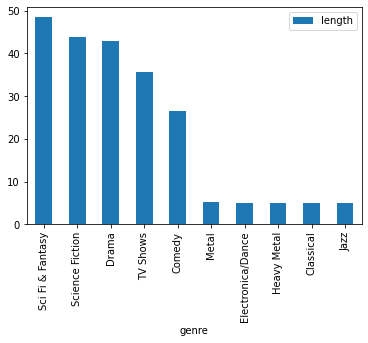

In [4]:
command = """
        SELECT (AVG(tracks.Milliseconds) / 60000) as length, genres.Name
        FROM tracks
        JOIN genres
        ON tracks.GenreId = genres.GenreId
        GROUP BY tracks.GenreId
        ORDER BY length DESC
        LIMIT 10
        """

result = connection.execute(command).all()

print('Genre'.center(20, '-'), 'Length'.center(10, '-'))
for row in result:
    print(row[1].ljust(20), '{:8.4f}'.format(row[0]))

df = pd.DataFrame(result, columns=['length', 'genre'])
df.plot.bar(x='genre')


### Total sales for year and genre
The desired information is in:
- 'Total' of 'invoices' table
- 'InvoiceDate' of 'invoices' table
- 'Name' of 'genres' table

However tables should be joined as:
- 'InvoiceId' of 'invoices' table to 'InvoiceId' of 'invoice_items' table
- 'TrackId' of 'invoice_items' table to 'TrackId' of 'tracks' table
- 'GenreId' of 'tracks' table to 'GenreId' of 'genres' table

-Year- -------Genre-------- -ToTal Sales-
 2009  Rock                 1561.23
 2009  Jazz                  185.13
 2009  Metal                 502.92
 2009  Alternative & Punk    466.29
 2009  Rock And Roll          13.86
 2009  Blues                 112.86
 2009  Latin                 789.03
 2009  Reggae                 58.41
 2009  Pop                    13.86
 2009  Soundtrack             45.54
 2009  Bossa Nova             13.86
 2009  Easy Listening         41.58
 2009  Heavy Metal            50.49
 2009  R&B/Soul               69.30
 2009  Electronica/Dance      17.82
 2009  World                  41.58
 2009  Hip Hop/Rap            27.72
 2010  Rock                 1364.77
 2010  Jazz                  173.25
 2010  Metal                 488.23
 2010  Alternative & Punk    264.38
 2010  Rock And Roll          27.72
 2010  Blues                  44.55
 2010  Latin                 804.14
 2010  Reggae                 58.41
 2010  Pop                    61.38
 2010  Soundtrack     

<AxesSubplot:xlabel='year'>

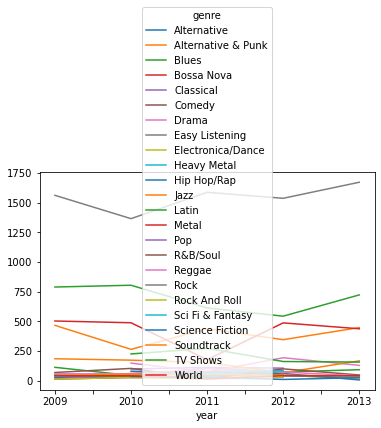

In [5]:
command = """
        SELECT SUM(invoices.Total), STRFTIME('%Y', invoices.InvoiceDate) as year, genres.name
        FROM invoices
        JOIN invoice_items
        ON invoices.InvoiceId = invoice_items.InvoiceId
        JOIN tracks
        ON invoice_items.TrackId = tracks.TrackId
        JOIN genres
        ON tracks.GenreId = genres.GenreId
        GROUP BY year, tracks.GenreId
        ORDER BY year
        """

result = connection.execute(command).all()

print('Year'.center(6, '-'), 'Genre'.center(20, '-'), 'ToTal Sales'.center(13, '-'))
for row in result:
    print(row[1].center(6), row[2].ljust(20), '{:7.2f}'.format(row[0]))
    

df = pd.DataFrame(result, columns=['sales', 'year', 'genre']).pivot(index='year', columns='genre', values='sales')
df.plot.line()


In [6]:
connection.close()